In [1]:
import torch

import torch.optim as optim

import numpy as np

from tqdm import tqdm

from plotting.plot import plot_results_panels
from data.loader import load_amazon
from modules.rq_vae import RQ_VAE

In [2]:
batch_size = 256
normalize_data = False
category = 'beauty'
train_loader, data_clean = load_amazon(category=category, batch_size=batch_size, normalize_data=normalize_data, train=True)

input_dimension = train_loader.dataset.shape[1]
hidden_dimension = [input_dimension, 512, 256]
latent_dimension = 256

num_codebook_layers = 3
codebook_clusters = 256
commitment_weight = 0.25

learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 200

model_id = (
    f"amazon-{category}-bs{batch_size}-norm{str(normalize_data)[0]}-"
    f"hd{'_'.join(map(str, hidden_dimension))}-ld{latent_dimension}-"
    f"cb{num_codebook_layers}x{codebook_clusters}-cw{commitment_weight}-"
    f"lr{learning_rate}-wd{weight_decay}-ep{num_epochs}"
)

In [3]:
model = RQ_VAE(
        input_dim = input_dimension,
        latent_dim = latent_dimension,
        hidden_dims = hidden_dimension,
        codebook_size = codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = num_codebook_layers,
        commitment_weight = commitment_weight,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [4]:
def train(model, train_loader, optimizer, num_epochs):
    model.train()
    
    epoch_progress = tqdm(range(num_epochs), total=num_epochs, desc="Training")
    results = []
    
    for epoch in epoch_progress:
        total_loss = 0
        total_reconstruction_loss = 0
        total_commit_loss = 0
        p_unique = 0
        if(epoch == 0):
            kmeans_init_data = torch.Tensor(data_clean[torch.arange(min(20000, len(data_clean)))]).to(device, dtype=torch.float32)
            model(kmeans_init_data)
            
        for batch in train_loader:
            batch = batch.to(device).float()
            optimizer.zero_grad()
            result = model(batch)
            result.loss.backward()
            optimizer.step()
            
            total_loss += result.loss.item()
            total_reconstruction_loss += result.reconstruction_loss.item()
            total_commit_loss += result.rqvae_loss.item()
            p_unique += result.p_unique_ids.item()
        epoch_stats = {"Epoch": epoch,
                        "Loss": total_loss / len(train_loader),
                        "Reconstruction Loss": total_reconstruction_loss / len(train_loader),
                        "Commitment Loss": total_commit_loss / len(train_loader),
                        "Prob Unique IDs": p_unique / len(train_loader)}
        epoch_progress.set_postfix(epoch_stats)
        results.append(epoch_stats)
    return results

In [5]:
losses = train(model, train_loader, optimizer, num_epochs)
torch.save(model.state_dict(), f"models/{model_id}.pth")

Training: 100%|██████████| 200/200 [03:04<00:00,  1.09it/s, Epoch=199, Loss=181, Reconstruction Loss=180, Commitment Loss=1.35, Prob Unique IDs=0.999]   


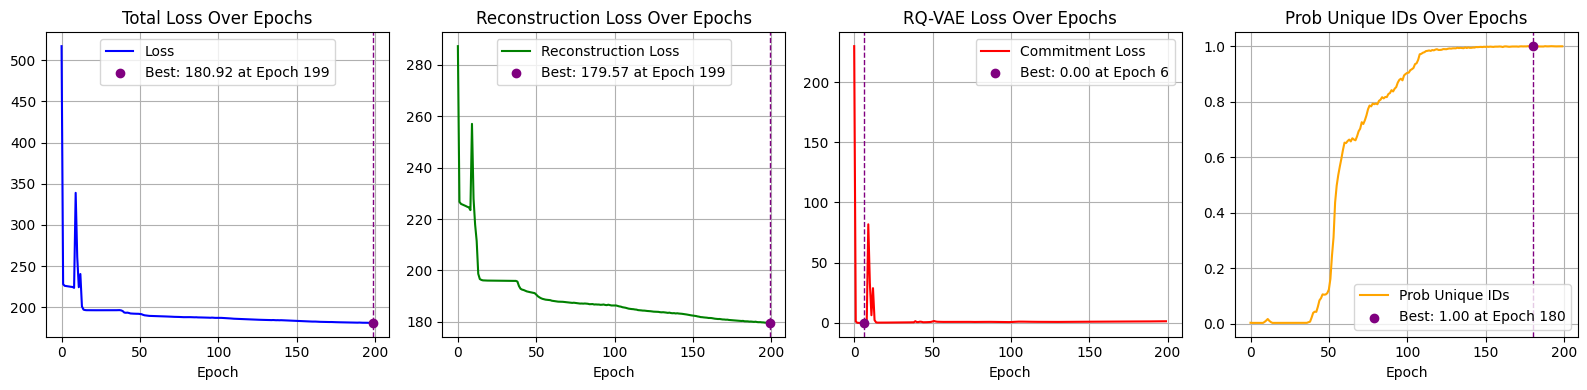

In [8]:

# Plot configuration
plot_configs = [
    ('Loss', 'Total Loss Over Epochs', 'blue', 'low'),
    ('Reconstruction Loss', 'Reconstruction Loss Over Epochs', 'green', 'low'),
    ('Commitment Loss', 'RQ-VAE Loss Over Epochs', 'red', 'low'),
    ('Prob Unique IDs', 'Prob Unique IDs Over Epochs', 'orange', 'high'),
]

fig = plot_results_panels(losses, plot_configs)
fig.savefig(f"plots/{model_id}.png", dpi=600, bbox_inches='tight')

In [7]:
sem_ids = []

for datapoint in tqdm(data_clean, desc="Getting semantic ids"):
    product = datapoint.to(device).float()
    
    with torch.no_grad():
        sem_id = model.get_semantic_id_single(product)
        sem_ids.append(sem_id)
        
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)
np.unique([x.cpu() for x in sem_ids], axis=0, return_counts=True)

Getting semantic ids: 100%|██████████| 11500/11500 [00:23<00:00, 490.23it/s]


(array([[  0,   1, 245],
        [  0,   8, 248],
        [  0,  28, 248],
        ...,
        [255, 241, 219],
        [255, 249, 146],
        [255, 249, 248]]),
 array([1, 1, 1, ..., 1, 1, 1]))